In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd # pip install geopandas
import pysal as ps # conda install -c anaconda pysal= 2.1
import scipy
from scipy.spatial import KDTree
import contextily as cx
from sklearn.cluster import DBSCAN
import plotly.io as pio
import plotly.express as px
import matplotlib.colors as colors

# functions

In [99]:
def continent(region, asia, america, africa):
    continent=region
    if region in asia:
        continent='asia'
    if region in america:
        continent='america'
    if region in africa:
        continent='africa'
    return continent

In [137]:
def quality(source):
    quality='moderate'
    if source in [1,2]:
        quality='bad'
    elif source in [4,5]:
        quality='good'
    return quality

# Import data

In [100]:
missing=gpd.read_file('Missing_Migrants_Global_Figures.geojson', sep=',')

In [101]:
missing['Region of Incident'].value_counts()

North America         2203
Northern Africa       1792
Mediterranean         1623
Central America       1010
Southern Asia          968
Western Africa         924
Europe                 463
Eastern Africa         401
Western Asia           311
South-eastern Asia     209
South America          171
Caribbean              108
Middle Africa           72
Southern Africa         10
Eastern Asia             8
Central Asia             1
Name: Region of Incident, dtype: int64

In [102]:
america_regions=['North America', 'Central America', 'South America', 'Caribbean']

### Analysis year by year

In [496]:
asia=['Southern Asia', 'South-eastern Asia', 'Southern Asia (P)', 'Central Asia', 'Western Asia', 'Western / Southern Asia (P)',
     'Western / Southern Asia', 'Eastern Asia', 'Western Asia (P)', 'Eastern Asia (P)']
africa=['Northern Africa', 'Sub-Saharan Africa (P)', 'Northern Africa (P)', 'Western Africa', 'Eastern Africa',
       'Sub-Saharan Africa', 'Middle Africa', 'Eastern Africa (P)', 'Western Africa (P)', 'Southern Africa']
america=['Central America', 'Latin America / Caribbean (P)', 'South America', 'Caribbean', 'South America (P)', 'Caribbean (P)',
        'Central America (P)','North America']

In [104]:
missing['Continent of Origin']=missing['Region of Origin'].apply(lambda x : continent(x, asia, america, africa))

In [105]:
missing.to_csv('testt.csv', sep=';')

In [106]:
missing['Continent of Origin'].value_counts()

america    3429
africa     3331
asia       1887
Unknown    1523
Mixed        99
Europe        4
Oceania       1
Name: Continent of Origin, dtype: int64

In [107]:
missing_continent=missing[missing['Continent of Origin'].isin(['africa', 'america', 'asia'])].copy()

In [108]:
missing_year_r=missing_continent[['Incident year','Continent of Origin',
                   'Total Number of Dead and Missing']].groupby(['Incident year','Continent of Origin'], as_index=False).sum()



In [110]:
fig = px.bar(missing_year_r, x="Incident year", y="Total Number of Dead and Missing", barmode='group',color="Continent of Origin")
fig=fig.update_layout(title="Number of Death and Missing by Continent",title_x=0.7)

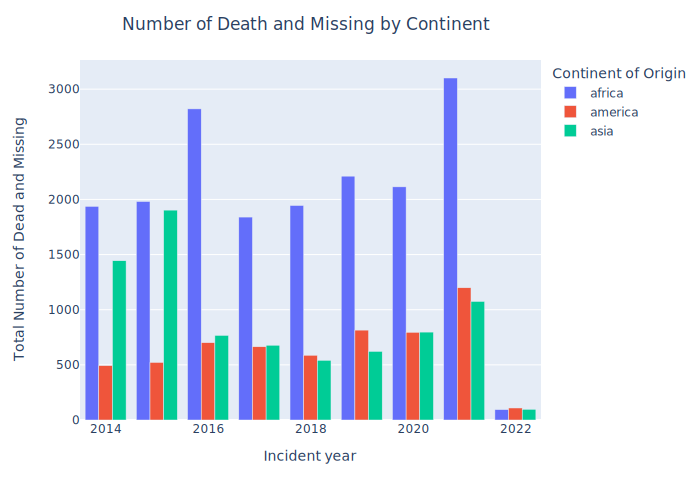

In [111]:
fig.show(renderer="svg")

In [118]:
missing_continent_np=missing_continent.copy()

In [120]:
missing_continent_np['Region of Origin']=missing_continent_np['Region of Origin'].apply(lambda x : x.replace(' (P)', ''))

In [121]:
missing_year_africa=missing_continent_np[['Incident year','Region of Origin',
                   'Total Number of Dead and Missing']].groupby(['Incident year','Region of Origin'], as_index=False).sum()



In [122]:
missing_year_africa=missing_year_africa[missing_year_africa['Region of Origin'].isin(africa)]

In [132]:
fig = px.bar(missing_year_africa, x="Incident year", y="Total Number of Dead and Missing",color="Region of Origin")
fig=fig.update_layout(title="Number of Death and Missing",title_x=0.25)

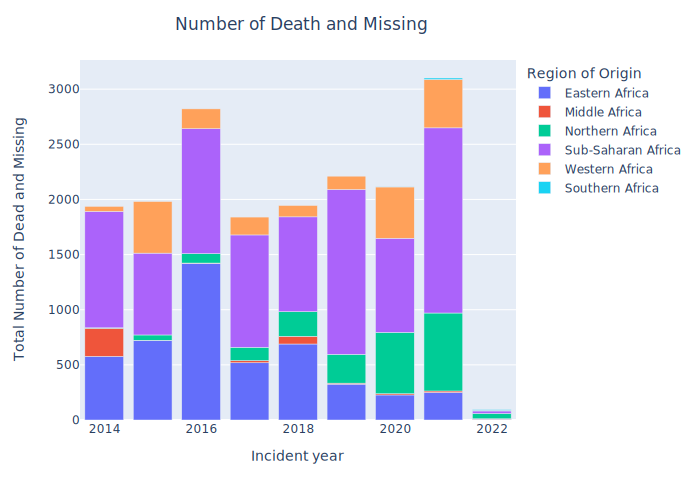

In [133]:
fig.show(renderer="svg")

### source quality

In [136]:
missing['Source Quality'].value_counts()

2.0    2949
4.0    2377
5.0    2336
1.0    1358
3.0    1214
Name: Source Quality, dtype: int64

In [139]:
missing['quality_b']=missing['Source Quality'].apply(lambda x : quality(x))

In [144]:
missing_qua=missing[missing['quality_b'].isin(['good', 'bad'])].copy()

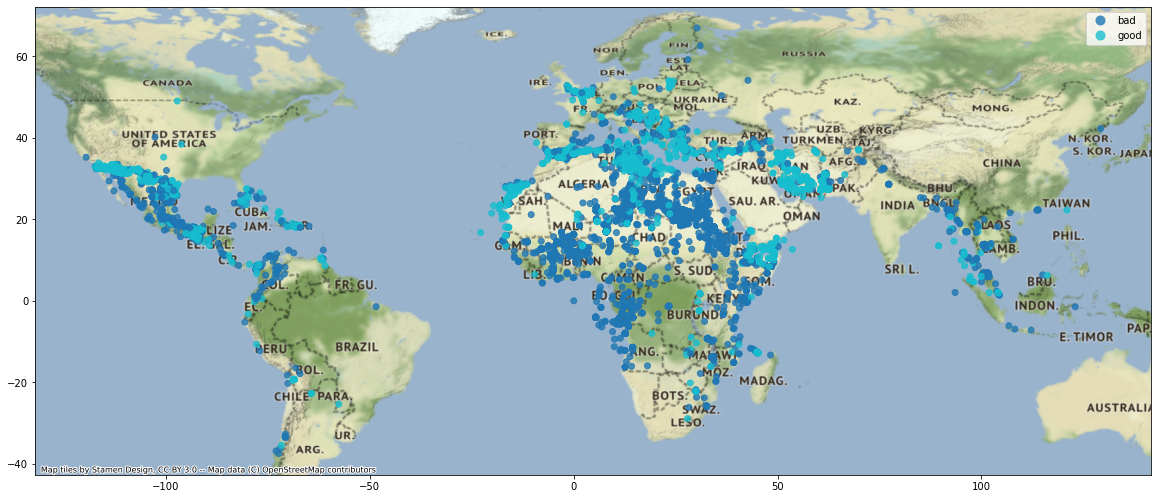

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax=missing_qua.plot(ax=ax,column='quality_b',legend=True,alpha=0.8, legend_kwds={ 'bbox_to_anchor': (1, 1)},
              )
cx.add_basemap(ax, crs=missing_qua.crs)

### clustering quality since 2019

In [321]:
missing_qua['long']=missing_qua.geometry.x
missing_qua['lat']=missing_qua.geometry.y
missing_qua=missing_qua[~missing_qua.long.isna()].copy()

In [322]:
missing_qua_recent=missing_qua[missing_qua['Incident year'].isin([2019, 2020, 2021, 2022])]

## good

In [580]:
missing_qua_good=missing_qua_recent[missing_qua_recent['quality_b']=='good'].copy()

In [581]:
coordinates=missing_qua_good[['long', 'lat']].to_numpy()

In [582]:
model=DBSCAN(eps=250/6371., min_samples=30, algorithm='ball_tree', metric='haversine').fit(np.radians(coordinates))

In [583]:
labels=model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
perc_noise=n_noise_/len(missing_qua_good)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("percentage of noise: " + str(round(perc_noise,2)))
print("size: " + str(len(missing_qua_good)))


Estimated number of clusters: 10
Estimated number of noise points: 308
percentage of noise: 0.12
size: 2615


In [584]:
missing_qua_good['cluster']=model.labels_

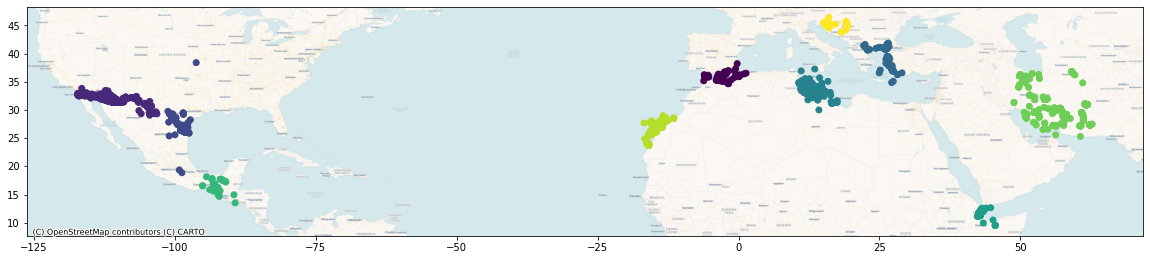

In [585]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = missing_qua_good[missing_qua_good['cluster']!=-1].plot(ax=ax,column='cluster')
cx.add_basemap(ax, crs=missing_qua_good.crs, source=cx.providers.CartoDB.Voyager)

## bad

In [586]:
missing_qua_bad=missing_qua_recent[missing_qua_recent['quality_b']=='bad'].copy()

In [587]:
coordinates=missing_qua_bad[['long', 'lat']].to_numpy()

In [588]:
model=DBSCAN(eps=250/6371., min_samples=30, algorithm='ball_tree', metric='haversine').fit(np.radians(coordinates))

In [589]:
labels=model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
perc_noise=n_noise_/len(missing_qua_good)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("percentage of noise: " + str(round(perc_noise,2)))
print("size: " + str(len(missing_qua_bad)))

Estimated number of clusters: 11
Estimated number of noise points: 589
percentage of noise: 0.23
size: 1504


In [590]:
missing_qua_bad['cluster']=model.labels_

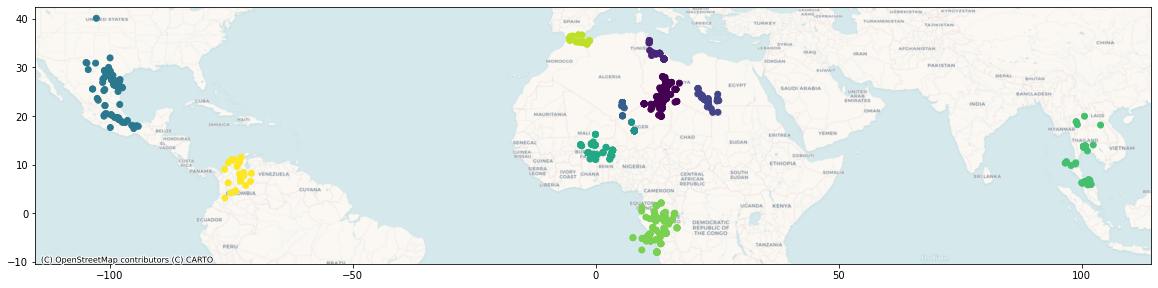

In [591]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = missing_qua_bad[missing_qua_bad['cluster']!=-1].plot(ax=ax,column='cluster')
cx.add_basemap(ax, crs=missing_qua_bad.crs, source=cx.providers.CartoDB.Voyager)

### comparison

In [592]:
missing_qua_bad_c=missing_qua_bad[missing_qua_bad['cluster']!=-1]
missing_qua_good_c=missing_qua_good[missing_qua_good['cluster']!=-1]

In [593]:
missing_qua_bad_c=missing_qua_bad_c.drop_duplicates('geometry')


In [594]:
missing_qua_bad_unary=missing_qua_bad_c.dissolve(by='cluster')

In [595]:
missing_qua_good_unary=missing_qua_good_c.dissolve(by='cluster')

In [596]:
quality_good_bad=gpd.GeoDataFrame(pd.concat([missing_qua_bad_unary, missing_qua_good_unary]))

In [597]:
quality_good_bad=quality_good_bad.reset_index()

In [598]:
quality_good_bad=quality_good_bad.sort_values('quality_b', ascending=False)

In [599]:
color_dict = {'bad':'#7a1d11', 'good':'#42bd56'}

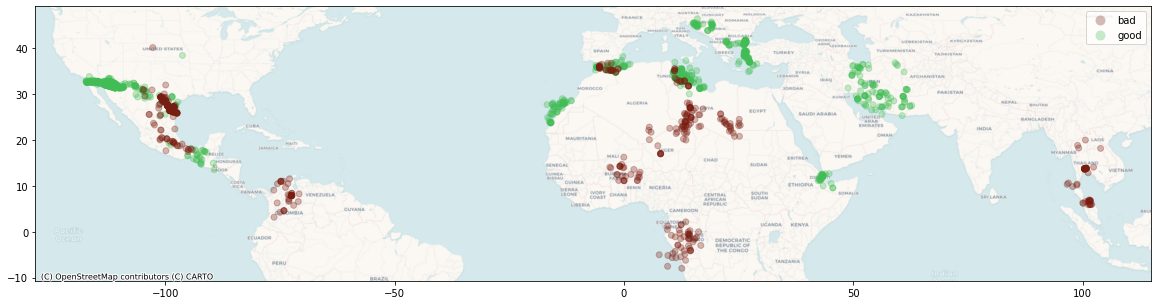

In [600]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = quality_good_bad.plot(ax=ax,column='quality_b', legend=True,alpha=0.3, legend_kwds={ 'bbox_to_anchor': (1, 1)},
                          cmap=colors.ListedColormap(list(color_dict.values())))
cx.add_basemap(ax, crs=quality_good_bad.crs, source=cx.providers.CartoDB.Voyager)

# Analysis 2021 by continent

In [519]:
missing_continent_2021=missing_continent_np[missing_continent_np['Incident year']==2021].copy()

In [520]:
missing_asia_2021=missing_continent_2021[(missing_continent_2021['Region of Origin'].isin(asia))&
                                         (~missing_continent_2021['Region of Incident'].isin(america_regions))]

In [521]:
missing_africa_2021=missing_continent_2021[(missing_continent_2021['Region of Origin'].isin(africa))&
                                         (~missing_continent_2021['Region of Incident'].isin(america_regions))]

In [522]:
missing_america_2021=missing_continent_2021[(missing_continent_2021['Region of Origin'].isin(america))]

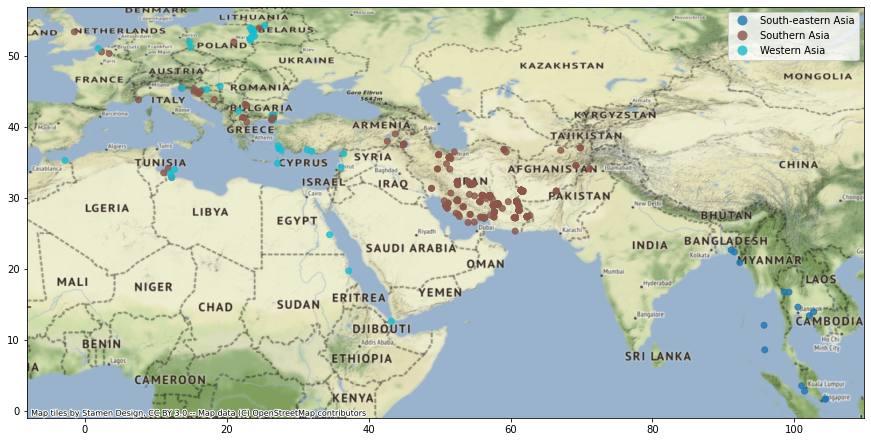

In [523]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax=missing_asia_2021.plot(ax=ax,column='Region of Origin',legend=True,alpha=0.8, legend_kwds={ 'bbox_to_anchor': (1, 1)},
              )
cx.add_basemap(ax, crs=missing_asia_2021.crs)

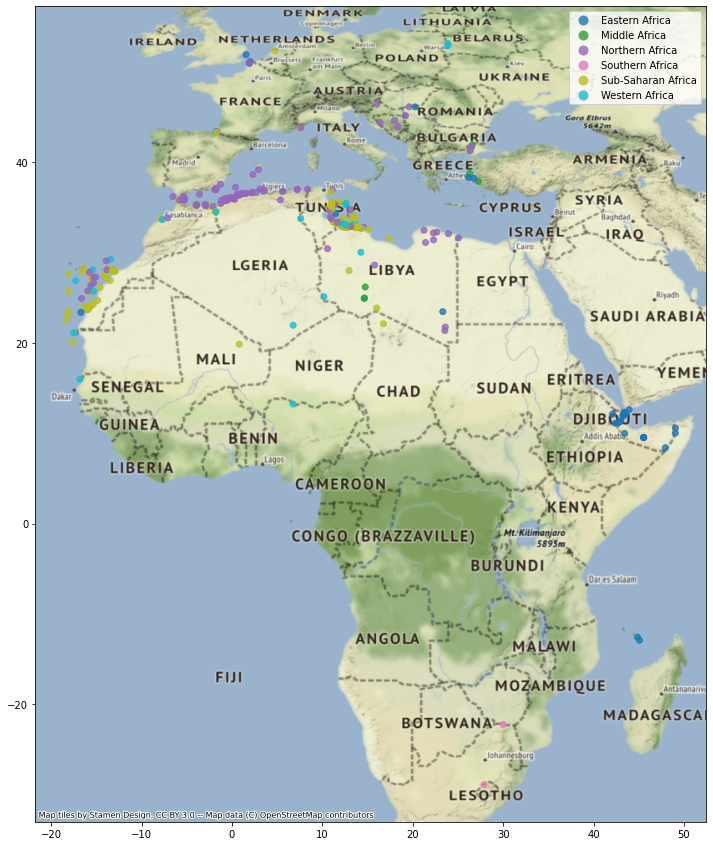

In [524]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax=missing_africa_2021.plot(ax=ax,column='Region of Origin',legend=True,alpha=0.8, legend_kwds={ 'bbox_to_anchor': (1, 1)},
              )
cx.add_basemap(ax, crs=missing_africa_2021.crs)

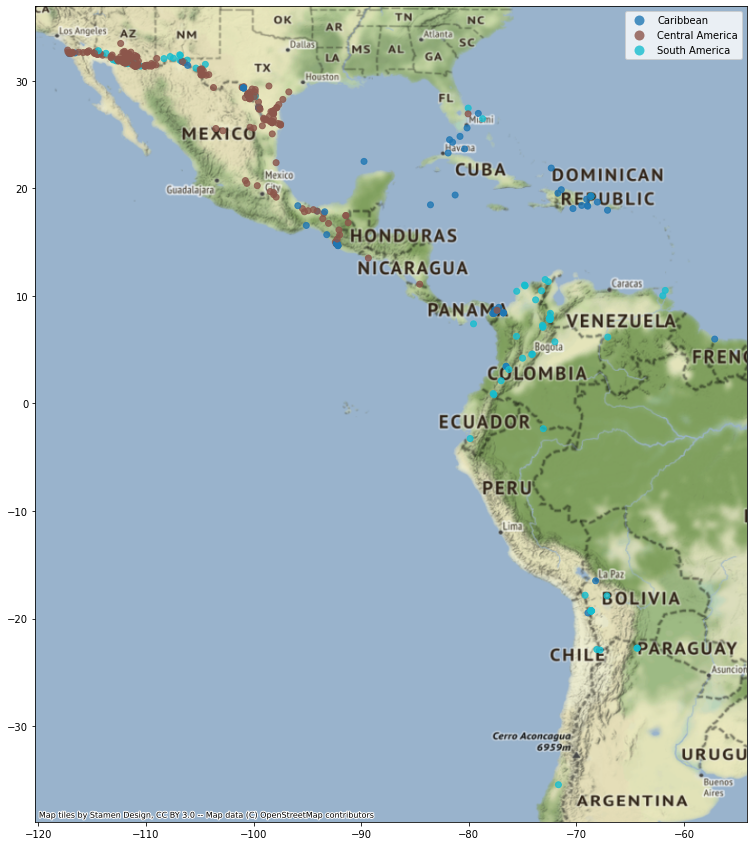

In [525]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax=missing_america_2021.plot(ax=ax,column='Region of Origin',legend=True,alpha=0.8, legend_kwds={ 'bbox_to_anchor': (1, 1)},
              )
cx.add_basemap(ax, crs=missing_america_2021.crs)

# Comparison 2016-2017 and 2020-2021

### Analysis 2016-2017

In [608]:
missing_continent_1617=missing_continent_np[missing_continent_np['Incident year'].isin([2016, 2017])].copy()

In [609]:
missing_continent_1617['long']=missing_continent_1617.geometry.x
missing_continent_1617['lat']=missing_continent_1617.geometry.y
missing_continent_1617=missing_continent_1617[~missing_continent_1617.long.isna()].copy()

In [610]:
coordinates=missing_continent_1617[['long', 'lat']].to_numpy()

In [611]:
model=DBSCAN(eps=200/6371., min_samples=30, algorithm='ball_tree', metric='haversine').fit(np.radians(coordinates))

In [612]:
labels=model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
perc_noise=n_noise_/len(missing_continent_1617)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("percentage of noise:" + str(round(perc_noise,2)))

Estimated number of clusters: 11
Estimated number of noise points: 540
percentage of noise:0.28


In [613]:
missing_continent_1617['cluster']=model.labels_

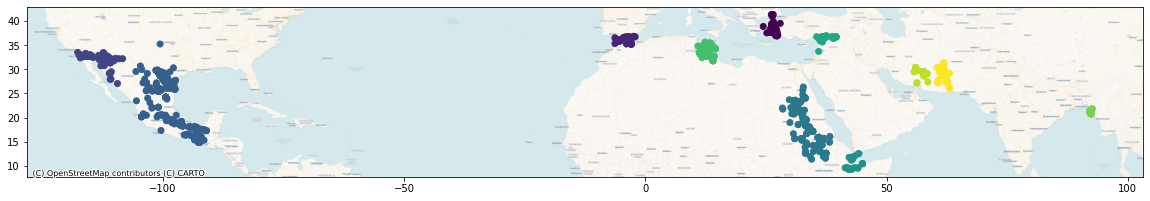

In [614]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = missing_continent_1617[missing_continent_1617['cluster']!=-1].plot(ax=ax,column='cluster')
cx.add_basemap(ax, crs=missing_continent_1617.crs, source=cx.providers.CartoDB.Voyager)

### Analysis 2020-2021

In [601]:
missing_continent_2021=missing_continent_np[missing_continent_np['Incident year'].isin([2020, 2021])].copy()

In [602]:
missing_continent_2021['long']=missing_continent_2021.geometry.x
missing_continent_2021['lat']=missing_continent_2021.geometry.y
missing_continent_2021=missing_continent_2021[~missing_continent_2021.long.isna()].copy()

In [603]:
coordinates=missing_continent_2021[['long', 'lat']].to_numpy()

In [604]:
model=DBSCAN(eps=200/6371., min_samples=30, algorithm='ball_tree', metric='haversine').fit(np.radians(coordinates))

In [605]:
labels=model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
perc_noise=n_noise_/len(missing_continent_2021)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("percentage of noise:" + str(round(perc_noise,2)))

Estimated number of clusters: 9
Estimated number of noise points: 484
percentage of noise:0.17


In [606]:
missing_continent_2021['cluster']=model.labels_

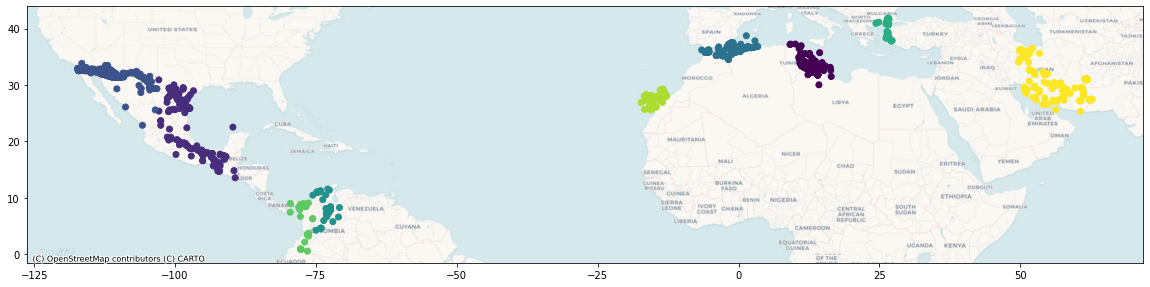

In [607]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = missing_continent_2021[missing_continent_2021['cluster']!=-1].plot(ax=ax,column='cluster')
cx.add_basemap(ax, crs=missing_continent_2021.crs, source=cx.providers.CartoDB.Voyager)